<a href="https://colab.research.google.com/github/KORALLLL/MTUCI_EMNIST/blob/Sasha/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Сверточная нейронная сеть архитектуры LeNet**
Тренировочный датасет: MNIST + EMNIST letters

Датасет для теста: dataset of DreamTeam

Кол-во изображения для тренировки: 36960

Кол-во изображения для теста: 16784

Функция потерь: Cross Entropy Loss

Оптимизатор: adam

Величина градиентного шага: 0.001

Размер батча: 1120

Кол-во эпох: 100

In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as bar
import pickle

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:

!git clone https://github.com/KORALLLL/MTUCI_EMNIST.git

Cloning into 'MTUCI_EMNIST'...
remote: Enumerating objects: 36437, done.
remote: Counting objects: 100% (12797/12797), done.
remote: Compressing objects: 100% (12680/12680), done.
remote: Total 36437 (delta 150), reused 12689 (delta 112), pack-reused 23640
Receiving objects: 100% (36437/36437), 128.33 MiB | 31.73 MiB/s, done.
Resolving deltas: 100% (435/435), done.


In [4]:
emnist_train = torchvision.datasets.EMNIST('./', split='letters', download = True, train = True)
mnist_train = torchvision.datasets.EMNIST('./', split='mnist', download = True, train = True)
emnist_val = torchvision.datasets.EMNIST('./', split='letters', download = True, train = False)
mnist_val = torchvision.datasets.EMNIST('./', split='mnist', download = True, train = False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

emnist_train_data = emnist_train.data
mnist_train_data = mnist_train.data
train_data = torch.cat([emnist_train_data[:24960], mnist_train_data[:12000]], dim=0).float().unsqueeze(1).to(device) / 255

emnist_val_data = emnist_val.data
mnist_val_data = mnist_val.data
val_data = torch.cat([emnist_val_data, mnist_val_data], dim=0).float().unsqueeze(1).to(device) / 255

temp_emnist_train_labels = emnist_train.targets[:24960]
emnist_train_labels = []

temp_emnist_val_labels = emnist_val.targets
emnist_val_labels = []

for i in range(len(temp_emnist_train_labels)):
  if temp_emnist_train_labels[i]==15:
    emnist_train_labels.append(torch.tensor(0))
  elif temp_emnist_train_labels[i]>15:
    emnist_train_labels.append(temp_emnist_train_labels[i]+8)
  else:
    emnist_train_labels.append(temp_emnist_train_labels[i]+9)

for i in range(len(temp_emnist_val_labels)):
  if temp_emnist_val_labels[i]==15:
    emnist_val_labels.append(torch.tensor(0))
  elif temp_emnist_val_labels[i]>15:
    emnist_val_labels.append(temp_emnist_val_labels[i] + 8)
  else:
    emnist_val_labels.append(temp_emnist_val_labels[i]+9)

mnist_train_labels = mnist_train.targets
train_labels = torch.cat([torch.stack(emnist_train_labels[:24960]), mnist_train_labels[:12000]], dim=0).to(device)

mnist_val_labels = mnist_val.targets
val_labels = torch.cat([torch.stack(emnist_val_labels), mnist_val_labels], dim=0).to(device)


file = open('MTUCI_EMNIST/dataset.pkl', 'rb')
test_dataset = pickle.load(file)
file.close()

test_data = test_dataset['data'].numpy()
test_data = np.flip(test_data, axis = 3)
test_data = np.rot90(test_data, k=1, axes=(2,3))
test_data = 1 - test_data
test_data = torch.from_numpy(test_data).float().to(device)
test_labels = test_dataset['targets'].to(device)


100%|██████████| 561753746/561753746 [00:10<00:00, 51343767.06it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [ ]:
#x_train = mnist_train.train_data
#y_train = mnist_train.targets
#x_test = mnist_test.test_data
#y_test = mnist_test.targets

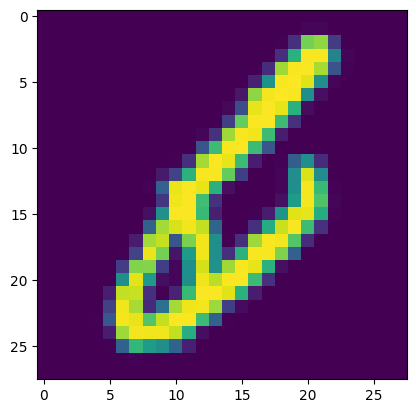

In [5]:
import matplotlib.pyplot as plt
plt.imshow(val_data.cpu()[10][0])
plt.show()

In [ ]:
#x_train = x_train.unsqueeze(1).float()
#x_test = x_test.unsqueeze(1).float()
#x_train.shape

torch.Size([60000, 28, 28])
ekdmekd


torch.Size([60000, 1, 28, 28])

##Первая версия архитектуры после экспериментов (0.68-0.7)

In [116]:
class LeNet5(torch.nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=2,
                                 kernel_size=3, padding=0)
    self.conv2 = torch.nn.Conv2d(in_channels=2, out_channels=4,
                                 kernel_size=3, padding=0)
    self.conv3 = torch.nn.Conv2d(in_channels=4, out_channels=8,
                                 kernel_size=3, padding=1)
    self.conv4 = torch.nn.Conv2d(in_channels=8, out_channels=8,
                                 kernel_size=3, padding=1)
    #длина/ширина -> 2d
    self.act1 = torch.nn.Tanh()
    self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

    self.conv5 = torch.nn.Conv2d(in_channels=8, out_channels=16,
                                 kernel_size=3, padding=1)

    self.conv6 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.conv7 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=0)

    self.act2 = torch.nn.Tanh()
    self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

    self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
    self.act3 = torch.nn.Tanh()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act4 = torch.nn.Tanh()
    self.fc3 = torch.nn.Linear(84, 35)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.act1(x)
    x = self.pool1(x)

    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    #x = self.conv8(x)
    #x = self.conv9(x)
    x = self.act2(x)
    x = self.pool2(x)

    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.act3(x)
    x = self.fc2(x)
    x = self.act4(x)
    x = self.fc3(x)

    return x

lenet5 = LeNet5()







##Тестовая архитектура 2

In [117]:
class LeNet52(torch.nn.Module):
  def __init__(self):
    super(LeNet52, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=2,
                                 kernel_size=3, padding=0)
    self.conv2 = torch.nn.Conv2d(in_channels=2, out_channels=4,
                                 kernel_size=3, padding=0)
    self.conv3 = torch.nn.Conv2d(in_channels=4, out_channels=8,
                                 kernel_size=3, padding=1)
    #self.conv4 = torch.nn.Conv2d(in_channels=8, out_channels=8,
          #                       kernel_size=3, padding=1)
    #длина/ширина -> 2d
    self.act1 = torch.nn.Tanh()
    self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

    self.conv5 = torch.nn.Conv2d(in_channels=8, out_channels=16,
                                 kernel_size=3, padding=1)

    self.conv6 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=1)
    self.conv7 = torch.nn.Conv2d(in_channels=16, out_channels=16,
                                 kernel_size=3, padding=0)

    self.act2 = torch.nn.Tanh()
    self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

    self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
    self.act3 = torch.nn.Tanh()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act4 = torch.nn.Tanh()
    self.fc3 = torch.nn.Linear(84, 35)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    #x = self.conv4(x)
    x = self.act1(x)
    x = self.pool1(x)

    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    #x = self.conv8(x)
    #x = self.conv9(x)
    x = self.act2(x)
    x = self.pool2(x)

    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.act3(x)
    x = self.fc2(x)
    x = self.act4(x)
    x = self.fc3(x)

    return x

lenet5 = LeNet52()







In [118]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [119]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

tensor(0.2015)
tensor(0.3489)
tensor(0.3963)
tensor(0.4503)
tensor(0.4831)
tensor(0.5353)
tensor(0.5703)
tensor(0.5888)
tensor(0.5923)
tensor(0.6200)
tensor(0.6337)
tensor(0.6194)
tensor(0.6481)
tensor(0.6523)
tensor(0.6533)
tensor(0.6558)
tensor(0.6566)
tensor(0.6541)
tensor(0.6713)
tensor(0.6716)
tensor(0.6808)
tensor(0.6661)
tensor(0.6723)
tensor(0.6903)
tensor(0.6686)
tensor(0.6789)
tensor(0.6808)
tensor(0.6738)
tensor(0.6784)
tensor(0.6867)
tensor(0.6883)
tensor(0.6839)
tensor(0.6917)
tensor(0.6973)
tensor(0.6887)
tensor(0.6918)
tensor(0.6884)
tensor(0.6907)
tensor(0.6867)
tensor(0.6845)
tensor(0.6822)
tensor(0.6872)
tensor(0.6878)
tensor(0.6907)
tensor(0.6923)
tensor(0.6830)
tensor(0.6904)
tensor(0.6858)
tensor(0.6819)
tensor(0.6854)
tensor(0.6960)
tensor(0.6897)
tensor(0.6911)
tensor(0.6741)
tensor(0.6791)
tensor(0.6890)
tensor(0.6753)
tensor(0.6915)
tensor(0.6809)
tensor(0.6788)
tensor(0.6842)
tensor(0.6792)
tensor(0.6814)
tensor(0.6795)
tensor(0.6789)
tensor(0.6773)
tensor(0.6

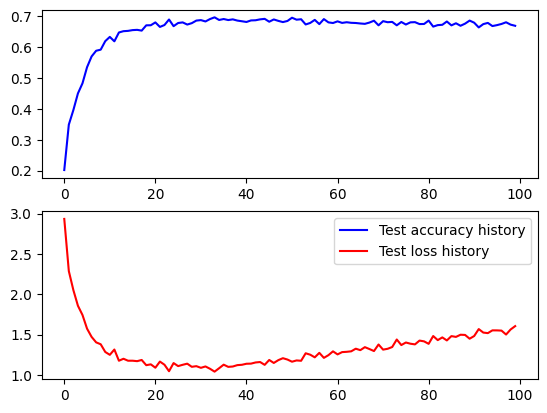

In [120]:
batch_size = 1120
test_accuracy_history = []
test_loss_history = []
train_accuracy_history = []
#x_test = x_test.to(device)
#y_test = y_test.to(device)
for epoch in range(100):
  order = np.random.permutation(len(train_data))
  for start_index in range(0, len(train_data), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index:start_index + batch_size]
    train_batch = train_data[batch_indexes].to(device)
    label_batch = train_labels[batch_indexes].to(device)

    preds = lenet5.forward(train_batch)

    loss_value = loss(preds, label_batch)
    loss_value.backward()

    optimizer.step()
  test_preds = lenet5.forward(test_data)
  test_loss_history.append(loss(test_preds, test_labels).data.cpu())

  accuracy = (test_preds.argmax(dim=1) == test_labels).float().mean().data.cpu()
  test_accuracy_history.append(accuracy)
  print(accuracy)

plt.subplot(2, 1, 1)
g1, = plt.plot(range(len(test_accuracy_history)), test_accuracy_history, c='b', label='Test accuracy history')
plt.subplot(2, 1, 2)
g2, = plt.plot(range(len(test_loss_history)), test_loss_history, c='r', label='Test loss history')
plt.legend(handles=[g1, g2])




In [ ]:
x = [1, 2, 3, 4, 5]
y = [u for u in x]
y_1 = [u**0.5 for u in x]
g1, = plt.plot(x, y, c='r', label='g1')
g2, = plt.plot(x, y_1, c='b', label='g2')
plt.legend(handles=[g1, g2])
plt.show()

In [ ]:
plt.plot(range(len(test_accuracy_history)), test_accuracy_history, c='blue', label='Train accuracy history')